# dataset

In [ ]:
# @title load

import pandas as pd

df = pd.read_csv('2020-2025.csv', parse_dates=['SALE DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154748 entries, 0 to 154747
Data columns (total 21 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   BOROUGH                         154748 non-null  int64         
 1   NEIGHBORHOOD                    154748 non-null  object        
 2   BUILDING CLASS CATEGORY         154748 non-null  object        
 3   TAX CLASS AT PRESENT            154718 non-null  object        
 4   BLOCK                           154748 non-null  int64         
 5   LOT                             154748 non-null  int64         
 6   EASEMENT                        0 non-null       float64       
 7   BUILDING CLASS AT PRESENT       154718 non-null  object        
 8   ADDRESS                         154748 non-null  object        
 9   APARTMENT NUMBER                23483 non-null   object        
 10  ZIP CODE                        154722 non-null  float64

In [ ]:
# @title clean

df = df.drop(columns=['EASEMENT'])
df['ZIP CODE'] = df['ZIP CODE'].astype('Int64')
df['YEAR BUILT'] = df['YEAR BUILT'].astype('Int64')
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].astype('Int64')

In [ ]:
# @title generic neighborhood processing

def process_neighborhood_data(df, neighborhood_name, min_year_built=None):
    df_filtered = df[(df['NEIGHBORHOOD'] == neighborhood_name) &
                     (df['APARTMENT NUMBER'].notna()) &
                     (df['BUILDING CLASS AT PRESENT'] =='R4') &
                     (df['SALE PRICE'] > 0)].copy()

    df_processed = df_filtered[['ADDRESS',
                                'APARTMENT NUMBER',
                                'ZIP CODE',
                                'YEAR BUILT',
                                'SALE PRICE',
                                'SALE DATE']].copy()

    if min_year_built is not None:
        df_processed = df_processed[df_processed['YEAR BUILT'] >= min_year_built].copy()

    df_processed['housenum'] = df_processed['ADDRESS'].str.split(' ').str[0]
    df_processed['streetname'] = (df_processed['ADDRESS'].str.split(' ').str[1] + ' ' +
                                  df_processed['ADDRESS'].str.split(' ').str[2].str.replace(',', ''))
    df_processed['aptno'] = df_processed['APARTMENT NUMBER']

    df_processed = df_processed.drop(columns=['ADDRESS', 'APARTMENT NUMBER'])

    return df_processed

In [ ]:
# for lic/ast
dflic = process_neighborhood_data(df, 'LONG ISLAND CITY', 2018)
dfast = process_neighborhood_data(df, 'ASTORIA', 2018)

In [ ]:
dflic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1906 entries, 22 to 154667
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ZIP CODE    1906 non-null   Int64         
 1   YEAR BUILT  1906 non-null   Int64         
 2   SALE PRICE  1906 non-null   int64         
 3   SALE DATE   1906 non-null   datetime64[ns]
 4   housenum    1906 non-null   object        
 5   streetname  1906 non-null   object        
 6   aptno       1906 non-null   object        
dtypes: Int64(2), datetime64[ns](1), int64(1), object(3)
memory usage: 122.8+ KB


In [ ]:
dfast.info()

<class 'pandas.core.frame.DataFrame'>
Index: 394 entries, 587 to 133302
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ZIP CODE    394 non-null    Int64         
 1   YEAR BUILT  394 non-null    Int64         
 2   SALE PRICE  394 non-null    int64         
 3   SALE DATE   394 non-null    datetime64[ns]
 4   housenum    394 non-null    object        
 5   streetname  394 non-null    object        
 6   aptno       394 non-null    object        
dtypes: Int64(2), datetime64[ns](1), int64(1), object(3)
memory usage: 25.4+ KB


In [ ]:
# @title extra clean up

dflic['housenum'] = dflic['housenum'].str.strip().replace(r'^(\d{2})(\d{2})$', r'\1-\2', regex=True)
dflic['streetname'] = dflic['streetname'].str.strip().replace(r'ST$', 'STREET', regex=True)

dfast['housenum'] = dfast['housenum'].str.strip().replace(r'^(\d{2})(\d{2})$', r'\1-\2', regex=True)
dfast['streetname'] = dfast['streetname'].str.strip().replace(r'ST$', 'STREET', regex=True)

# odd balls
dflic.loc[dflic['housenum']=='37-29', 'streetname'] = dflic.loc[dflic['housenum']=='37-29', 'streetname'].str.replace('32ND STREET', '32 STREET')
dflic.loc[dflic['housenum']=='41-21', 'streetname'] = dflic.loc[dflic['housenum']=='41-21', 'streetname'].str.replace('23RD STREET', '23 STREET')

dfast.loc[dfast['housenum']=='14-33', 'streetname'] = dfast.loc[dfast['housenum']=='14-33', 'streetname'].str.replace('31ST STREET', '31ST AVENUE')
dfast.loc[dfast['housenum']=='14-54', 'streetname'] = dfast.loc[dfast['housenum']=='14-54', 'streetname'].str.replace('31ST AVENUE', '31 AVENUE')
dfast.loc[dfast['housenum']=='14-35', 'streetname'] = 'BROADWAY'
dfast.loc[dfast['housenum']=='23-10', 'streetname'] = '30TH DRIVE'

In [ ]:
# @title soda for info

# !pip install -qU sodapy
# https://dev.socrata.com/foundry/data.cityofnewyork.us/8y4t-faws
# https://dev.socrata.com/docs/queries/order

from sodapy import Socrata
from concurrent.futures import ThreadPoolExecutor

DATA_URL = 'data.cityofnewyork.us'
DATA_SET = '8y4t-faws'

client = Socrata(DATA_URL, APP_TOKEN)
client.timeout = 60
MAX_WORKERS = 10

OPT_FIELD_MAP = {
    1: 'gross_sqft',
    2: 'owner',
    3: 'curtxbtot',
    4: 'curtxbextot',
}

def fetch_socrata_data(housenum_lo, street_name, aptno, field_name, opt):
    order_direction = 'ASC' if opt == 1 else 'DESC'

    params = {
        'limit': 1,
        'housenum_lo': str(housenum_lo),
        'street_name': str(street_name),
        'aptno': str(aptno),
        'order': f'year {order_direction}'
    }

    try:
        # 1st attemp
        results = client.get(DATA_SET, **params)
        if results:
            return results[0].get(field_name)

        # 2nd attemp
        if 'TH' in street_name.upper():
            params['street_name'] = str(street_name).replace('TH', '')
            results = client.get(DATA_SET, **params)
            if results:
                return results[0].get(field_name)

        return None # No results found after both attempts

    # generic error
    except Exception as e:
        print(f"Error fetching data for {housenum_lo}, {street_name}, {aptno}: {e}")
        return None

def process_socrata_result(raw_value, field_name):
    if raw_value is None:
        return None

    if field_name in ['gross_sqft', 'curtxbtot', 'curtxbextot']:
        try:
            return int(raw_value)
        except ValueError:
            return raw_value
    else:
        return raw_value

def check_info_sodapy(housenum_lo, street_name, aptno, opt=1):

    field_name = OPT_FIELD_MAP.get(opt)

    if field_name is None:
        return None

    raw_value = fetch_socrata_data(housenum_lo, street_name, aptno, field_name, opt)

    return process_socrata_result(raw_value, field_name)

def get_info_multithreaded_sodapy(df, opt=1):

    # temp []
    vals = [None] * len(df)
    opts = [opt] * len(df)

    # opt1 sqft, opt2 owner, opt3 taxtot, opt4 taxextot
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:

        housenums = df['housenum'].tolist()
        streetnames = df['streetname'].tolist()
        aptnos = df['aptno'].tolist()

        for i, result in enumerate(executor.map(check_info_sodapy, housenums, streetnames, aptnos, opts)):
            vals[i] = result

    return vals

In [ ]:
# @title soda debug

import requests
import json

# for debugging
def check_aptno(housenum_lo, street_name, aptno):
    url = 'https://data.cityofnewyork.us/resource/8y4t-faws.json'

    r = requests.get(f'{url}?housenum_lo={housenum_lo}&street_name={street_name}&aptno={aptno}&$$app_token={APP_TOKEN}')
    j = r.json()

    if j:
        return int(j[-1].get('gross_sqft'))
    else:
        return None

In [ ]:
%%time
dflic['sqft'] = get_info_multithreaded_sodapy(dflic, 1)
dfast['sqft'] = get_info_multithreaded_sodapy(dfast, 1)

CPU times: user 6.49 s, sys: 518 ms, total: 7.01 s
Wall time: 1min 17s


In [ ]:
dflic = dflic.dropna(subset=['sqft'])
dfast = dfast.dropna(subset=['sqft'])
dflic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1883 entries, 22 to 154667
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ZIP CODE    1883 non-null   Int64         
 1   YEAR BUILT  1883 non-null   Int64         
 2   SALE PRICE  1883 non-null   int64         
 3   SALE DATE   1883 non-null   datetime64[ns]
 4   housenum    1883 non-null   object        
 5   streetname  1883 non-null   object        
 6   aptno       1883 non-null   object        
 7   sqft        1883 non-null   float64       
dtypes: Int64(2), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 136.1+ KB


In [ ]:
dfast.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 587 to 133302
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ZIP CODE    392 non-null    Int64         
 1   YEAR BUILT  392 non-null    Int64         
 2   SALE PRICE  392 non-null    int64         
 3   SALE DATE   392 non-null    datetime64[ns]
 4   housenum    392 non-null    object        
 5   streetname  392 non-null    object        
 6   aptno       392 non-null    object        
 7   sqft        392 non-null    float64       
dtypes: Int64(2), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 28.3+ KB


In [ ]:
dflic.to_csv('2018-2025-lic.csv', index=False)
dfast.to_csv('2018-2025-ast.csv', index=False)

# lic / ast

In [ ]:
# @title new df

import pandas as pd

dflic = pd.read_csv('2018-2025-lic.csv', parse_dates=['SALE DATE'])
dfast = pd.read_csv('2018-2025-ast.csv', parse_dates=['SALE DATE'])

In [ ]:
dflic['$/sqft'] = round(dflic['SALE PRICE'] / dflic['sqft'])
dflic

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft
0,11101,2018,1875000,2025-05-30,23-15,44TH DRIVE,PH202,986.0,1902.0
1,11101,2023,751514,2025-05-28,11-52,44 DRIVE,4A,477.0,1576.0
2,11101,2023,812609,2025-05-23,11-52,44TH DRIVE,2B,555.0,1464.0
3,11101,2023,776970,2025-05-22,11-52,44TH DRIVE,4D,474.0,1639.0
4,11101,2018,1551678,2025-05-21,23-15,44TH DRIVE,PH203,687.0,2259.0
...,...,...,...,...,...,...,...,...,...
1878,11101,2018,748000,2020-01-03,11-12,44TH DRIVE,4D,586.0,1276.0
1879,11101,2018,825000,2020-01-03,11-12,44TH DRIVE,2D,586.0,1408.0
1880,11101,2018,922304,2020-01-03,21-30,44TH DRIVE,3G,739.0,1248.0
1881,11101,2018,1404000,2020-01-03,11-12,44TH DRIVE,6I,994.0,1412.0


In [ ]:
dflic[(dflic['$/sqft']>500) & (dflic['$/sqft']<3000)].describe()

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,sqft,$/sqft
count,1727.0,1727.000000,1.727000e+03,1727,1727.000000,1727.000000
mean,11101.0,2019.105385,1.148142e+06,2022-11-13 10:22:51.627098880,770.046902,1488.234511
min,11101.0,2018.000000,3.549810e+05,2020-01-03 00:00:00,341.000000,628.000000
25%,11101.0,2018.000000,8.230510e+05,2021-08-09 12:00:00,598.500000,1320.000000
50%,11101.0,2018.000000,1.073789e+06,2022-12-02 00:00:00,705.000000,1462.000000
75%,11101.0,2020.000000,1.369546e+06,2024-01-13 12:00:00,947.000000,1642.000000
max,11101.0,2023.000000,3.188863e+06,2025-05-30 00:00:00,1959.000000,2516.000000
std,0.0,1.590605,4.158166e+05,NaN,239.336289,231.019031


<Axes: title={'center': 'lic 2018-2025 $ / sqft'}>

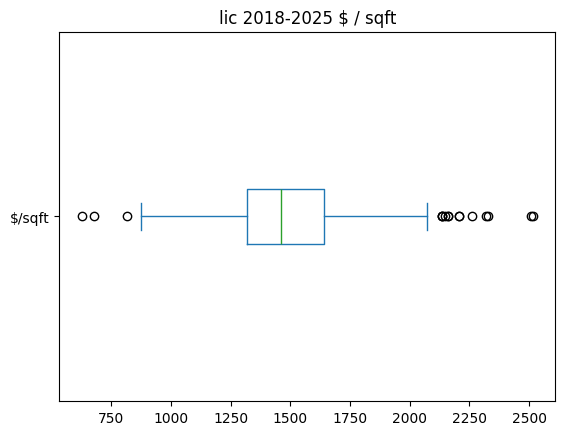

In [ ]:
# 1727 sample
# $/sqft median 1462
dflic[(dflic['$/sqft']>500) & (dflic['$/sqft']<3000)]['$/sqft'].plot.box(title='lic 2018-2025 $ / sqft', vert=False)

In [ ]:
dfast['$/sqft'] = round(dfast['SALE PRICE'] / dfast['sqft'])
dfast

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft
0,11105,2022,261770,2025-05-21,22-54,46TH STREET,301,1.0,261770.0
1,11105,2022,261770,2025-05-16,22-54,46TH STREET,501,1.0,261770.0
2,11106,2022,1155000,2025-05-13,31-27,CRESCENT STREET,2B,981.0,1177.0
3,11102,2020,650000,2025-05-09,23-23,30TH ROAD,4B,716.0,908.0
4,11106,2019,920000,2025-04-30,14-33,31ST AVENUE,2F,760.0,1211.0
...,...,...,...,...,...,...,...,...,...
387,11106,2019,567300,2021-01-14,14-33,31ST AVENUE,3C,494.0,1148.0
388,11106,2019,585983,2021-01-13,14-33,31ST AVENUE,1G,510.0,1149.0
389,11106,2019,840056,2021-01-08,14-33,31ST AVENUE,3F,728.0,1154.0
390,11106,2019,595817,2021-01-07,14-33,31ST AVENUE,3I,560.0,1064.0


In [ ]:
dfast[(dfast['$/sqft']>500) & (dfast['$/sqft']<2400)].describe()

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,sqft,$/sqft
count,374.000000,374.000000,3.740000e+02,374,374.000000,374.000000
mean,11104.221925,2019.692513,7.915949e+05,2023-02-03 05:19:34.331550976,682.893048,1153.965241
min,11102.000000,2018.000000,3.930000e+05,2020-12-29 00:00:00,352.000000,676.000000
25%,11102.000000,2019.000000,6.300000e+05,2021-11-22 00:00:00,560.000000,1064.500000
50%,11105.000000,2019.000000,7.265245e+05,2022-11-12 00:00:00,646.000000,1162.000000
75%,11106.000000,2021.000000,8.653848e+05,2024-06-19 12:00:00,732.500000,1243.750000
max,11106.000000,2023.000000,2.549000e+06,2025-05-13 00:00:00,1856.000000,1578.000000
std,1.858666,1.278445,2.862554e+05,NaN,203.170604,132.139849


<Axes: title={'center': 'ast 2018-2025 $ / sqft'}>

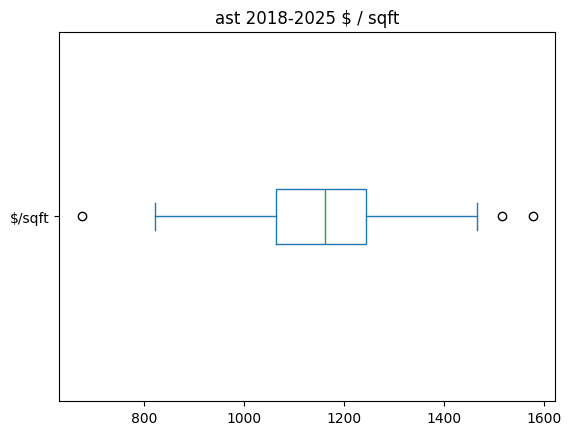

In [ ]:
# 374 sample
# $/sqft median 1162

dfast[(dfast['$/sqft']>500) & (dfast['$/sqft']<2400)]['$/sqft'].plot.box(title='ast 2018-2025 $ / sqft', vert=False)

# skyline

**Skyline Tower**, previously known as Court Square City View Tower, is a residential skyscraper in the Long Island City neighborhood of Queens in New York City. The building topped out in October 2019, surpassing One Court Square to become the tallest building in Queens at 762 feet.

- Highlights: Pets welcome · Swimming pool · Outdoor Space
- Address: 3 Ct Square W, Long Island City, NY 11101
- Floors: 67
- Opened: 2021
- Cost: $700 million
- Construction started: 2017
- Developer: Risland US Chris Xu and United Construction & Development Group
- Architecture firm: Hill West Architects
- Floor area: 762,000 square feet (70,800 m2)

In [ ]:
# @title 2315 save to csv
%%time
'''
df2315 = dflic[(dflic['housenum']=='23-15') & (dflic['streetname']=='44TH DRIVE')].copy()

df2315['owner'] = get_info_multithreaded_sodapy(df2315, 2)
df2315['curtxbtot'] = get_info_multithreaded_sodapy(df2315, 3)
# df2315['curtxbextot'] = get_info_multithreaded_sodapy(df2315, 4)

df2315.to_csv('23-15.csv', index=False)
''

CPU times: user 4.94 s, sys: 401 ms, total: 5.34 s
Wall time: 57.8 s


In [ ]:
# @title reload and EDA

import pandas as pd

df2315 = pd.read_csv('23-15.csv', parse_dates=['SALE DATE'])

In [ ]:
df2315.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ZIP CODE    900 non-null    int64         
 1   YEAR BUILT  900 non-null    int64         
 2   SALE PRICE  900 non-null    int64         
 3   SALE DATE   900 non-null    datetime64[ns]
 4   housenum    900 non-null    object        
 5   streetname  900 non-null    object        
 6   aptno       900 non-null    object        
 7   sqft        900 non-null    float64       
 8   $/sqft      900 non-null    float64       
 9   owner       900 non-null    object        
 10  curtxbtot   900 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 77.5+ KB


In [ ]:
df2315.head()

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
0,11101,2018,1875000,2025-05-30,23-15,44TH DRIVE,PH202,986.0,1902.0,"ELKANICH, BONNIE",133679
1,11101,2018,1551678,2025-05-21,23-15,44TH DRIVE,PH203,687.0,2259.0,RISLAND NEW YORK LLC,93135
2,11101,2018,1980973,2025-05-16,23-15,44TH DRIVE,6012,969.0,2044.0,RISLAND NEW YORK LLC,131329
3,11101,2018,1100000,2025-05-12,23-15,44TH DRIVE,907,704.0,1562.0,"WONG, ADAM GAH JUIN",95485
4,11101,2018,1187500,2025-05-09,23-15,44TH DRIVE,3609,625.0,1900.0,"LEE, CHEONG WAI",84712


In [ ]:
df2315[df2315['aptno']=='PH202']

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
0,11101,2018,1875000,2025-05-30,23-15,44TH DRIVE,PH202,986.0,1902.0,"ELKANICH, BONNIE",133679
166,11101,2018,2293313,2023-11-10,23-15,44TH DRIVE,PH202,986.0,2326.0,"ELKANICH, BONNIE",133679
365,11101,2018,161342986,2022-07-13,23-15,44TH DRIVE,PH202,986.0,163634.0,"ELKANICH, BONNIE",133679


In [ ]:
df2315['$/sqft'].describe()

,$/sqft
count,900.000000
mean,30492.661111
std,82885.889644
min,0.000000
25%,1459.000000
50%,1660.500000
75%,1878.000000
max,403357.000000


In [ ]:
df2315[df2315['$/sqft'] > 50000]

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
295,11101,2018,161342986,2022-07-13,23-15,44TH DRIVE,4711,1326.0,121676.0,BAKER 111 LLC,182353
296,11101,2018,161342986,2022-07-13,23-15,44TH DRIVE,4706,705.0,228855.0,"MAI, LYUYU",95583
297,11101,2018,161342986,2022-07-13,23-15,44TH DRIVE,619,484.0,333353.0,"WEN, OU",65614
298,11101,2018,161342986,2022-07-13,23-15,44TH DRIVE,617,453.0,356166.0,"YU, YANG",61403
299,11101,2018,161342986,2022-07-13,23-15,44TH DRIVE,6303,687.0,234852.0,"BERNARD, JAMES",93135
...,...,...,...,...,...,...,...,...,...,...,...
400,11101,2018,161342986,2022-07-13,23-15,44TH DRIVE,2809,625.0,258149.0,ONE OVAL LLC,84712
401,11101,2018,161342986,2022-07-13,23-15,44TH DRIVE,4211,1326.0,121676.0,"MUTRYN, MARY J",182353
402,11101,2018,161342986,2022-07-13,23-15,44TH DRIVE,5801,969.0,166505.0,"HUANG, HAIXIANG",131329
403,11101,2018,161342986,2022-07-13,23-15,44TH DRIVE,5910,972.0,165991.0,"SCHOLL, JESSICA",131819


In [ ]:
df2315['SALE PRICE'].value_counts().sort_index(ascending=False).head(10)

,count
SALE PRICE,
161342986,106
21400000,13
15427300,12
3738805,2
3230318,3
3188863,2
3113288,2
2900000,1
2728910,1


In [ ]:
# have to exclude these since sale price is a bulk sale price

df2315[df2315['SALE PRICE']>3738805].head(50)

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
93,11101,2018,21400000,2024-05-09,23-15,44TH DRIVE,4401,969.0,22085.0,WONG BROTHERS' REALTY INC.,131329
94,11101,2018,21400000,2024-05-09,23-15,44TH DRIVE,4411,1326.0,16139.0,WONG BROTHERS' REALTY INC.,182353
95,11101,2018,21400000,2024-05-09,23-15,44TH DRIVE,4109,975.0,21949.0,WONG BROTHERS' REALTY INC.,134267
96,11101,2018,21400000,2024-05-09,23-15,44TH DRIVE,3809,975.0,21949.0,WONG BROTHERS' REALTY INC.,134267
97,11101,2018,21400000,2024-05-09,23-15,44TH DRIVE,3301,930.0,23011.0,WONG BROTHERS' REALTY INC.,126039
98,11101,2018,21400000,2024-05-09,23-15,44TH DRIVE,3112,672.0,31845.0,WONG BROTHERS' REALTY INC.,91078
99,11101,2018,21400000,2024-05-09,23-15,44TH DRIVE,3102,997.0,21464.0,WONG BROTHERS' REALTY INC.,135149
100,11101,2018,21400000,2024-05-09,23-15,44TH DRIVE,6111,1326.0,16139.0,WONG BROTHERS' REALTY INC.,179804
101,11101,2018,21400000,2024-05-09,23-15,44TH DRIVE,5211,1326.0,16139.0,WONG BROTHERS' REALTY INC.,179804
102,11101,2018,21400000,2024-05-09,23-15,44TH DRIVE,2608,978.0,21881.0,WONG BROTHERS' REALTY INC.,134659


In [ ]:
# these are smaller bulk sales

df2315[df2315['SALE PRICE'] == 3738805]

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
22,11101,2018,3738805,2024-12-18,23-15,44TH DRIVE,PH406,470.0,7955.0,LAMNG CORP.,209774
23,11101,2018,3738805,2024-12-18,23-15,44TH DRIVE,PH406,470.0,7955.0,LAMNG CORP.,209774


In [ ]:
df2315[df2315['SALE PRICE'] == 3230318]

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
864,11101,2018,3230318,2021-03-29,23-15,44TH DRIVE,1402,997.0,3240.0,THE BENITO BARBA TRUST AGREEMENT,135149
865,11101,2018,3230318,2021-03-29,23-15,44TH DRIVE,807,704.0,4589.0,THE BENITO BARBA TRUST AGREEMENT,95485
866,11101,2018,3230318,2021-03-29,23-15,44TH DRIVE,601,644.0,5016.0,THE BENITO BARBA TRUST AGREEMENT,87357


In [ ]:
df2315[df2315['SALE PRICE'] == 3188863]

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
525,11101,2018,3188863,2022-02-25,23-15,44TH DRIVE,2312,672.0,4745.0,"MADAN, KULDEEP S",0
526,11101,2018,3188863,2022-02-25,23-15,44TH DRIVE,2311,1272.0,2507.0,"MADAN, KULDEEP S",263538


In [ ]:
df2315[df2315['SALE PRICE'] == 3113288]

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
74,11101,2018,3113288,2024-06-25,23-15,44TH DRIVE,PH208,470.0,6624.0,LPA PROPERTY TRUST,179609
77,11101,2018,3113288,2024-06-25,23-15,44TH DRIVE,PH208,470.0,6624.0,LPA PROPERTY TRUST,179609


In [ ]:
df2315[df2315['SALE PRICE'] == 2900000]

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
236,11101,2018,2900000,2023-02-17,23-15,44TH DRIVE,PH308,470.0,6170.0,SKYLINE UNIVERSAL LLC,179609


In [ ]:
df2315[df2315['SALE PRICE'] == 2728910]

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
91,11101,2018,2728910,2024-05-17,23-15,44TH DRIVE,5511,1326.0,2058.0,SUMMERWINGS LLC,179804


In [ ]:
df2315[df2315['SALE PRICE'] == 2710009]

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
18,11101,2018,2710009,2024-12-27,23-15,44TH DRIVE,5911,1326.0,2044.0,RISLAND NEW YORK LLC,179804
19,11101,2018,2710009,2024-12-27,23-15,44TH DRIVE,5911,1326.0,2044.0,RISLAND NEW YORK LLC,179804


In [ ]:
# looks like 2610739 is the cutline

df2315[(df2315['SALE PRICE'] < 2710009) &
       (df2315['SALE PRICE'] > 2000000)
       ].sort_values(by='SALE PRICE', ascending=False)

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
65,11101,2018,2702744,2024-07-29,23-15,44TH DRIVE,5811,1326.0,2038.0,SUMMER BROOK GROUP LLC,179804
64,11101,2018,2702744,2024-07-29,23-15,44TH DRIVE,5811,1326.0,2038.0,SUMMER BROOK GROUP LLC,179804
181,11101,2018,2695480,2023-09-26,23-15,44TH DRIVE,5711,1326.0,2033.0,"DE JUNIAC, PHILIPPE BEGOUGNE",179804
245,11101,2018,2659034,2023-01-04,23-15,44TH DRIVE,5411,1326.0,2005.0,SKYLINE TOWER UNIT 5411 LLC,179804
13,11101,2018,2649700,2025-03-12,23-15,44TH DRIVE,PH408,470.0,5638.0,HOLDING 12 SUB LLC,179609
730,11101,2018,2610739,2021-07-16,23-15,44TH DRIVE,5011,1326.0,1969.0,"KUO, SHEAU-WU",182353
417,11101,2018,2583038,2022-06-22,23-15,44TH DRIVE,3811,1326.0,1948.0,"SHAH, SONAL",182353
735,11101,2018,2536185,2021-07-14,23-15,44TH DRIVE,4111,1326.0,1913.0,"ZHOUYUAN, DUAN",182353
150,11101,2018,2480850,2023-12-15,23-15,44TH DRIVE,PH102,986.0,2516.0,COURT SQUARE 3 LLC,133679
118,11101,2018,2452839,2024-03-28,23-15,44TH DRIVE,4711,1326.0,1850.0,BAKER 111 LLC,182353


In [ ]:
# the lower end is also not realistic
# 492000 as cutline

df2315[df2315['SALE PRICE'] < 2710009].sort_values(by='SALE PRICE', ascending=True).head(30)

,ZIP CODE,YEAR BUILT,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
646,11101,2018,10,2021-09-18,23-15,44TH DRIVE,1606,420.0,0.0,"WANG, RAN",56898
45,11101,2018,27741,2024-10-04,23-15,44TH DRIVE,4202,985.0,28.0,"MOON, TAE",133581
44,11101,2018,27741,2024-10-04,23-15,44TH DRIVE,4202,985.0,28.0,"MOON, TAE",133581
42,11101,2018,28448,2024-10-17,23-15,44TH DRIVE,630,665.0,43.0,YELLOW HOMESTEAD LLC,90197
43,11101,2018,28448,2024-10-17,23-15,44TH DRIVE,630,665.0,43.0,YELLOW HOMESTEAD LLC,90197
14,11101,2018,30178,2025-03-07,23-15,44TH DRIVE,3109,625.0,48.0,"MO, DIKUN",84712
5,11101,2018,36389,2025-05-08,23-15,44TH DRIVE,2002,997.0,36.0,"LIU, YUZHUI",135149
212,11101,2018,492000,2023-06-06,23-15,44TH DRIVE,404,437.0,1126.0,"JIN, SHIYIFANG",59249
519,11101,2018,591496,2022-03-02,23-15,44TH DRIVE,402,405.0,1460.0,"LLCL, LLC",54940
461,11101,2018,603018,2022-05-10,23-15,44TH DRIVE,301,470.0,1283.0,"LEONG, CHIN CHIA",63755


In [ ]:
df2 = df2315[(df2315['SALE PRICE'] <= 2610739) &
             (df2315['SALE PRICE'] >= 492000)
             ].copy()
df2 = df2.drop(columns=['ZIP CODE', 'YEAR BUILT'])
df2 = df2.reset_index(drop=True)
df2

,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
0,1875000,2025-05-30,23-15,44TH DRIVE,PH202,986.0,1902.0,"ELKANICH, BONNIE",133679
1,1551678,2025-05-21,23-15,44TH DRIVE,PH203,687.0,2259.0,RISLAND NEW YORK LLC,93135
2,1980973,2025-05-16,23-15,44TH DRIVE,6012,969.0,2044.0,RISLAND NEW YORK LLC,131329
3,1100000,2025-05-12,23-15,44TH DRIVE,907,704.0,1562.0,"WONG, ADAM GAH JUIN",95485
4,1187500,2025-05-09,23-15,44TH DRIVE,3609,625.0,1900.0,"LEE, CHEONG WAI",84712
...,...,...,...,...,...,...,...,...,...
739,1681381,2021-02-10,23-15,44TH DRIVE,1211,1272.0,1322.0,"CHEUNG, KELLY SET MOI",175106
740,937488,2021-02-09,23-15,44TH DRIVE,2509,625.0,1500.0,"CHEN, LONG",84712
741,959757,2021-02-09,23-15,44TH DRIVE,3209,625.0,1536.0,"WANG, AIHUA",84712
742,1108437,2021-02-08,23-15,44TH DRIVE,4203,687.0,1613.0,"CHEN, HAI JUAN",93135


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SALE PRICE  744 non-null    int64         
 1   SALE DATE   744 non-null    datetime64[ns]
 2   housenum    744 non-null    object        
 3   streetname  744 non-null    object        
 4   aptno       744 non-null    object        
 5   sqft        744 non-null    float64       
 6   $/sqft      744 non-null    float64       
 7   owner       744 non-null    object        
 8   curtxbtot   744 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 52.4+ KB


In [ ]:
# @title df2
# a more reasonable price analysis

df2.describe()

,SALE PRICE,SALE DATE,sqft,$/sqft,curtxbtot
count,7.440000e+02,744,744.000000,744.000000,744.000000
mean,1.273043e+06,2022-07-01 20:00:00,795.748656,1606.881720,108348.538978
min,4.920000e+05,2020-07-06 00:00:00,400.000000,1126.000000,54254.000000
25%,9.688585e+05,2021-08-02 18:00:00,635.000000,1427.750000,87651.000000
50%,1.201484e+06,2022-02-28 12:00:00,724.000000,1587.500000,98128.000000
75%,1.563686e+06,2023-05-24 18:00:00,972.000000,1754.000000,131916.750000
max,2.610739e+06,2025-05-30 00:00:00,1326.000000,4928.000000,186662.000000
std,3.980797e+05,NaN,220.398092,268.356534,30352.875946


In [ ]:
df2

,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
0,1875000,2025-05-30,23-15,44TH DRIVE,PH202,986.0,1902.0,"ELKANICH, BONNIE",133679
1,1551678,2025-05-21,23-15,44TH DRIVE,PH203,687.0,2259.0,RISLAND NEW YORK LLC,93135
2,1980973,2025-05-16,23-15,44TH DRIVE,6012,969.0,2044.0,RISLAND NEW YORK LLC,131329
3,1100000,2025-05-12,23-15,44TH DRIVE,907,704.0,1562.0,"WONG, ADAM GAH JUIN",95485
4,1187500,2025-05-09,23-15,44TH DRIVE,3609,625.0,1900.0,"LEE, CHEONG WAI",84712
...,...,...,...,...,...,...,...,...,...
739,1681381,2021-02-10,23-15,44TH DRIVE,1211,1272.0,1322.0,"CHEUNG, KELLY SET MOI",175106
740,937488,2021-02-09,23-15,44TH DRIVE,2509,625.0,1500.0,"CHEN, LONG",84712
741,959757,2021-02-09,23-15,44TH DRIVE,3209,625.0,1536.0,"WANG, AIHUA",84712
742,1108437,2021-02-08,23-15,44TH DRIVE,4203,687.0,1613.0,"CHEN, HAI JUAN",93135


<Axes: title={'center': '23-15 $ / sqft'}>

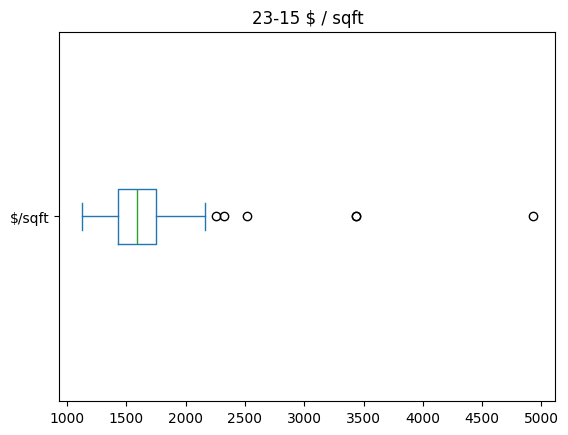

In [ ]:
df2['$/sqft'].plot.box(title='23-15 $ / sqft', vert=False)

In [ ]:
df2[df2['$/sqft'] > 2500]

,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot
121,2480850,2023-12-15,23-15,44TH DRIVE,PH102,986.0,2516.0,COURT SQUARE 3 LLC,133679
139,1444739,2023-11-09,23-15,44TH DRIVE,2206,420.0,3440.0,3 CV COURT SQUARE LLC,56898
140,1444739,2023-11-09,23-15,44TH DRIVE,2306,420.0,3440.0,3 CV COURT SQUARE LLC,56898
157,2316282,2023-08-23,23-15,44TH DRIVE,PH302,470.0,4928.0,"CHOW, SEAN SHU YAN",133679


<Axes: title={'center': '23-15 $ / sqft'}>

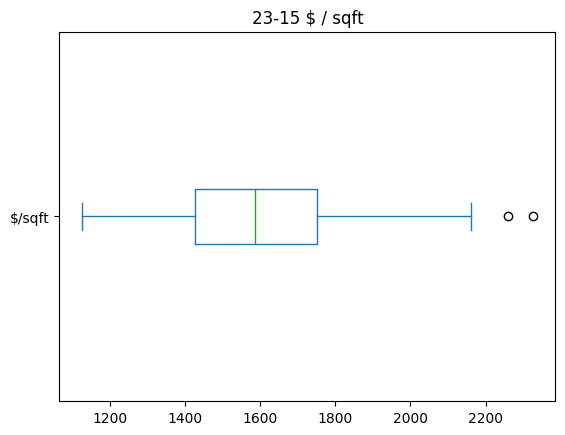

In [ ]:
df2[df2['$/sqft'] < 2500]['$/sqft'].plot.box(title='23-15 $ / sqft', vert=False)

In [ ]:
df2['month'] = df2['SALE DATE'].dt.month
df2['year'] = df2['SALE DATE'].dt.year
df2

,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot,month,year
0,1875000,2025-05-30,23-15,44TH DRIVE,PH202,986.0,1902.0,"ELKANICH, BONNIE",133679,5,2025
1,1551678,2025-05-21,23-15,44TH DRIVE,PH203,687.0,2259.0,RISLAND NEW YORK LLC,93135,5,2025
2,1980973,2025-05-16,23-15,44TH DRIVE,6012,969.0,2044.0,RISLAND NEW YORK LLC,131329,5,2025
3,1100000,2025-05-12,23-15,44TH DRIVE,907,704.0,1562.0,"WONG, ADAM GAH JUIN",95485,5,2025
4,1187500,2025-05-09,23-15,44TH DRIVE,3609,625.0,1900.0,"LEE, CHEONG WAI",84712,5,2025
...,...,...,...,...,...,...,...,...,...,...,...
739,1681381,2021-02-10,23-15,44TH DRIVE,1211,1272.0,1322.0,"CHEUNG, KELLY SET MOI",175106,2,2021
740,937488,2021-02-09,23-15,44TH DRIVE,2509,625.0,1500.0,"CHEN, LONG",84712,2,2021
741,959757,2021-02-09,23-15,44TH DRIVE,3209,625.0,1536.0,"WANG, AIHUA",84712,2,2021
742,1108437,2021-02-08,23-15,44TH DRIVE,4203,687.0,1613.0,"CHEN, HAI JUAN",93135,2,2021


<Axes: title={'center': '23-15 sales by month'}, xlabel='year,month'>

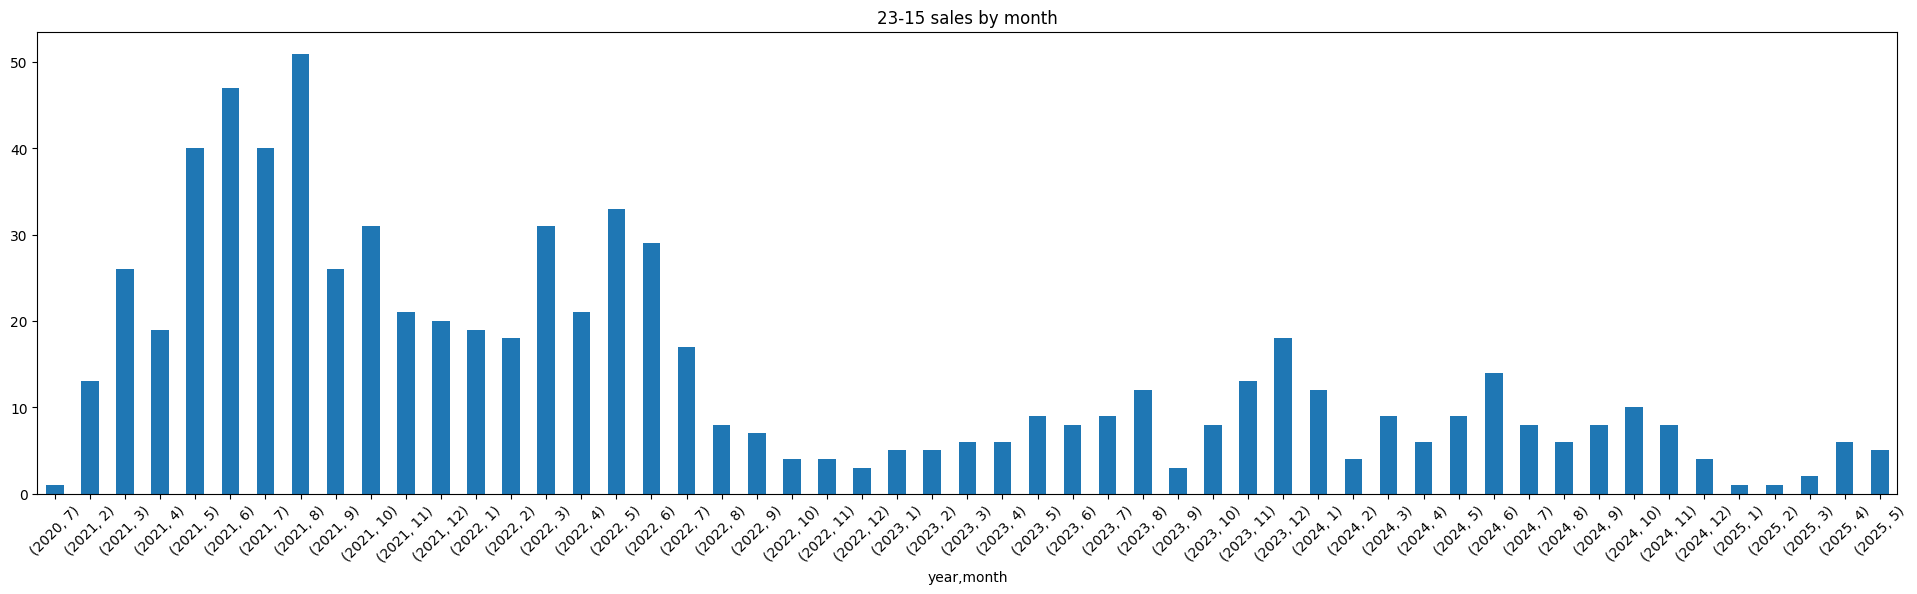

In [ ]:
df2.groupby(['year', 'month']).size().plot.bar(figsize=(24, 6), rot=45, title='23-15 sales by month')

In [ ]:
df2.sort_values('$/sqft', ascending=False).head(50)

,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot,month,year
157,2316282,2023-08-23,23-15,44TH DRIVE,PH302,470.0,4928.0,"CHOW, SEAN SHU YAN",133679,8,2023
140,1444739,2023-11-09,23-15,44TH DRIVE,2306,420.0,3440.0,3 CV COURT SQUARE LLC,56898,11,2023
139,1444739,2023-11-09,23-15,44TH DRIVE,2206,420.0,3440.0,3 CV COURT SQUARE LLC,56898,11,2023
121,2480850,2023-12-15,23-15,44TH DRIVE,PH102,986.0,2516.0,COURT SQUARE 3 LLC,133679,12,2023
137,2293313,2023-11-10,23-15,44TH DRIVE,PH202,986.0,2326.0,"ELKANICH, BONNIE",133679,11,2023
1,1551678,2025-05-21,23-15,44TH DRIVE,PH203,687.0,2259.0,RISLAND NEW YORK LLC,93135,5,2025
50,2092928,2024-08-05,23-15,44TH DRIVE,6112,969.0,2160.0,"DONG, YOUHENG",131329,8,2024
49,2092928,2024-08-05,23-15,44TH DRIVE,6112,969.0,2160.0,"DONG, YOUHENG",131329,8,2024
12,2082045,2025-03-03,23-15,44TH DRIVE,5901,969.0,2149.0,COURT SQUARE PROPERTY LLC,131329,3,2025
107,936001,2024-01-11,23-15,44TH DRIVE,6307,438.0,2137.0,"SKYLINE 6307, LLC",59347,1,2024


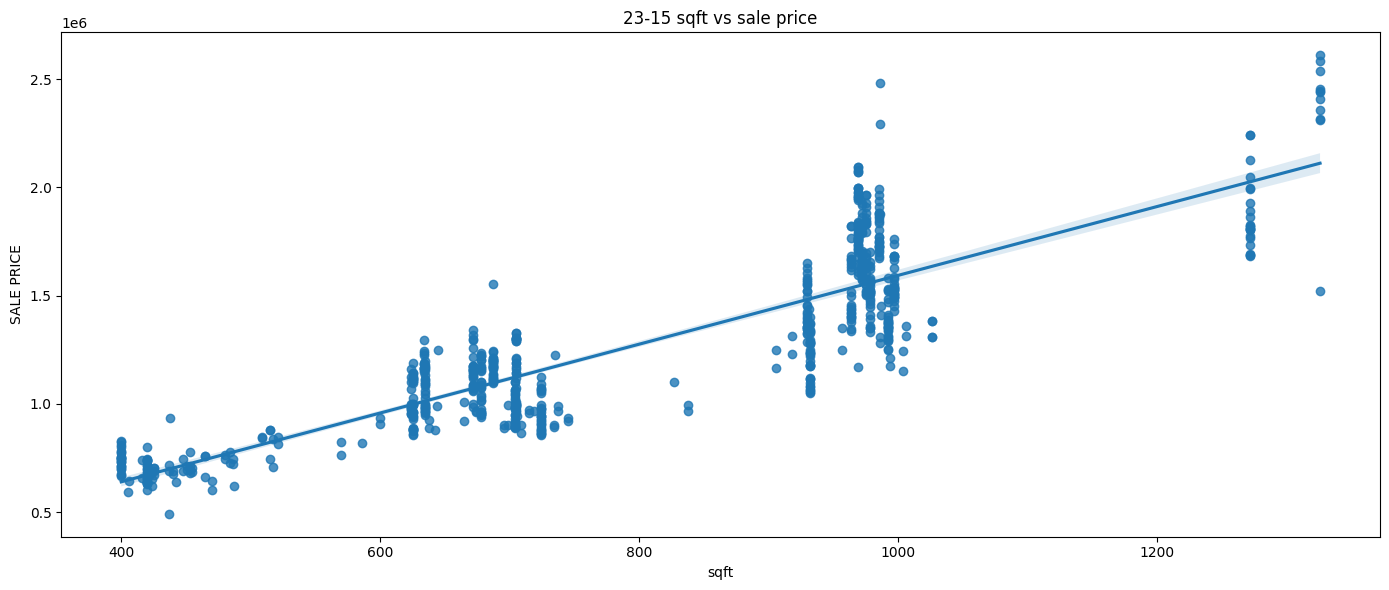

In [ ]:
# @title df3

import seaborn as sns
import matplotlib.pyplot as plt

df3 = df2[df2['$/sqft']<3000].copy()

plt.figure(figsize=(14, 6))
sns.regplot(df3, x='sqft', y='SALE PRICE')
plt.title('23-15 sqft vs sale price')
plt.tight_layout()

In [ ]:
df3.describe()

,SALE PRICE,SALE DATE,sqft,$/sqft,curtxbtot,month,year
count,7.410000e+02,741,741.000000,741.000000,741.000000,741.000000,741.000000
mean,1.271171e+06,2022-06-29 22:24:46.639676160,797.202429,1597.452092,108453.222672,6.375169,2022.005398
min,4.920000e+05,2020-07-06 00:00:00,400.000000,1126.000000,54254.000000,1.000000,2020.000000
25%,9.687730e+05,2021-07-30 00:00:00,635.000000,1427.000000,87651.000000,4.000000,2021.000000
50%,1.200278e+06,2022-02-28 00:00:00,724.000000,1587.000000,98128.000000,6.000000,2022.000000
75%,1.563500e+06,2023-05-18 00:00:00,972.000000,1752.000000,131819.000000,9.000000,2023.000000
max,2.610739e+06,2025-05-30 00:00:00,1326.000000,2516.000000,186662.000000,12.000000,2025.000000
std,3.969332e+05,NaN,219.647782,219.615621,30282.000286,3.034420,1.141347


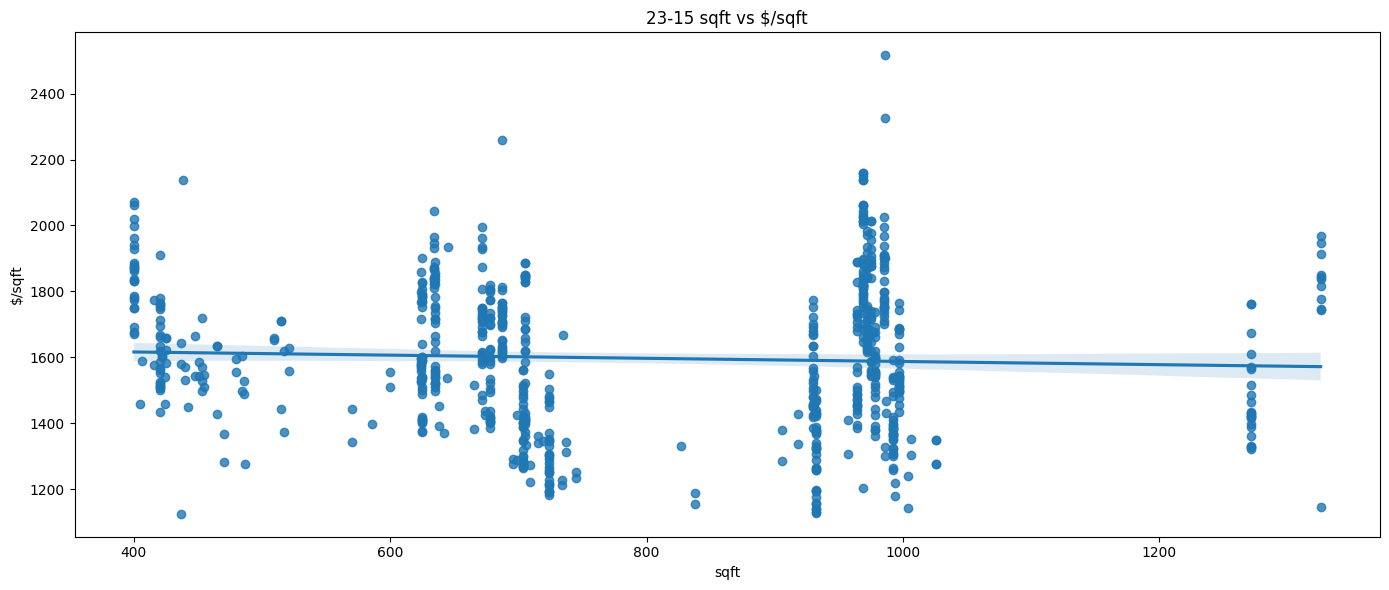

In [ ]:
plt.figure(figsize=(14, 6))
sns.regplot(df3, x='sqft', y='$/sqft')
plt.title('23-15 sqft vs $/sqft')
plt.tight_layout()

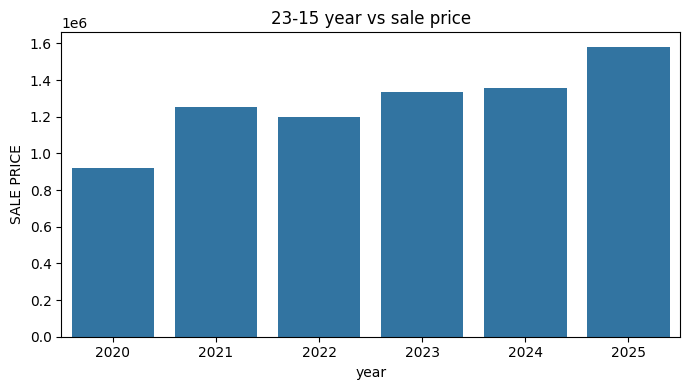

In [ ]:
plt.figure(figsize=(7, 4))
sns.barplot(df3.groupby('year')['SALE PRICE'].mean())
plt.title('23-15 year vs sale price')
plt.tight_layout()

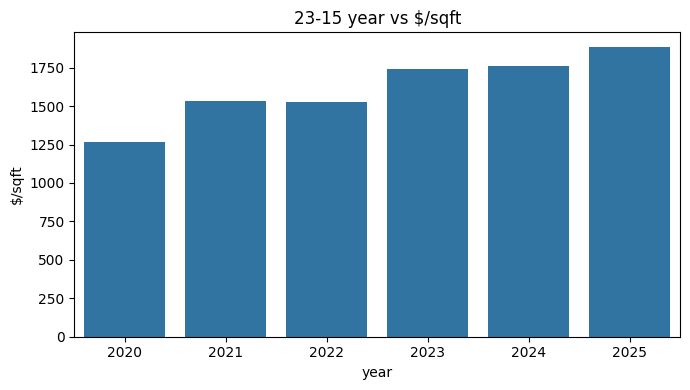

In [ ]:
plt.figure(figsize=(7, 4))
sns.barplot(df3.groupby('year')['$/sqft'].mean())
plt.title('23-15 year vs $/sqft')
plt.tight_layout()

In [ ]:
# @title tax
# tax class 2, bldg class R4

df3['tax/year'] = df3['curtxbtot'] * 0.125
df3['tax/year/sqft'] = round(df3['tax/year'] / df3['sqft'], 2)
df3['tax/month/sqft'] = round(df3['tax/year'] / 12 / df3['sqft'], 2)

In [ ]:
df3[['tax/year', 'tax/year/sqft', 'tax/month/sqft']].describe()

,tax/year,tax/year/sqft,tax/month/sqft
count,741.000000,741.000000,741.000000
mean,13556.652834,16.992321,1.414211
std,3785.250036,0.303244,0.025284
min,6781.750000,16.760000,1.400000
25%,10956.375000,16.940000,1.410000
50%,12266.000000,16.950000,1.410000
75%,16477.375000,16.950000,1.410000
max,23332.750000,23.880000,1.990000


<Axes: title={'center': '23-15 tax/month/sqft'}>

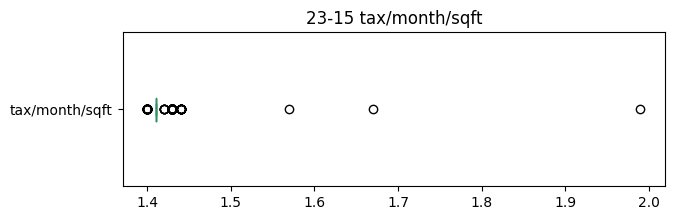

In [ ]:
df3['tax/month/sqft'].plot.box(title='23-15 tax/month/sqft', vert=False, figsize=(7, 2))

In [ ]:
# abnormal tax

df3[df3['tax/month/sqft']>1.5]

,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot,month,year,tax/year,tax/year/sqft,tax/month/sqft
191,1106173,2023-05-11,23-15,44TH DRIVE,709,625.0,1770.0,"HENRY, ROBERT DAWSON JR.",94408,5,2023,11801.00,18.88,1.57
508,1639300,2021-08-27,23-15,44TH DRIVE,712,977.0,1678.0,"THOMPSON, SCOTT R JR.",186662,8,2021,23332.75,23.88,1.99
655,1517924,2021-05-24,23-15,44TH DRIVE,708,978.0,1552.0,"MERTZ, THOMAS",156498,5,2021,19562.25,20.00,1.67


In [ ]:
# compare to others

df3.head()

,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot,month,year,tax/year,tax/year/sqft,tax/month/sqft
0,1875000,2025-05-30,23-15,44TH DRIVE,PH202,986.0,1902.0,"ELKANICH, BONNIE",133679,5,2025,16709.875,16.95,1.41
1,1551678,2025-05-21,23-15,44TH DRIVE,PH203,687.0,2259.0,RISLAND NEW YORK LLC,93135,5,2025,11641.875,16.95,1.41
2,1980973,2025-05-16,23-15,44TH DRIVE,6012,969.0,2044.0,RISLAND NEW YORK LLC,131329,5,2025,16416.125,16.94,1.41
3,1100000,2025-05-12,23-15,44TH DRIVE,907,704.0,1562.0,"WONG, ADAM GAH JUIN",95485,5,2025,11935.625,16.95,1.41
4,1187500,2025-05-09,23-15,44TH DRIVE,3609,625.0,1900.0,"LEE, CHEONG WAI",84712,5,2025,10589.000,16.94,1.41


<Axes: title={'center': '23-15 tax/month/sqft'}>

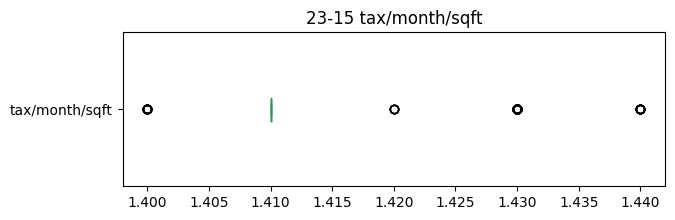

In [ ]:
df3[df3['tax/month/sqft']<1.5]['tax/month/sqft'].plot.box(title='23-15 tax/month/sqft', vert=False, figsize=(7, 2))

In [ ]:
df3[df3['tax/year']<6800]

,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot,month,year,tax/year,tax/year/sqft,tax/month/sqft
102,807711,2024-01-19,23-15,44TH DRIVE,5307,400.0,2019.0,"SKYLINE 5307, LLC",54254,1,2024,6781.75,16.95,1.41
103,828696,2024-01-19,23-15,44TH DRIVE,5907,400.0,2072.0,"SKYLINE 5907, LLC",54254,1,2024,6781.75,16.95,1.41
123,798796,2023-12-08,23-15,44TH DRIVE,6107,400.0,1997.0,"LOU, YUQING",54254,12,2023,6781.75,16.95,1.41
148,784266,2023-10-10,23-15,44TH DRIVE,6007,400.0,1961.0,"QU, JASMINE",54254,10,2023,6781.75,16.95,1.41
173,776158,2023-07-12,23-15,44TH DRIVE,5807,400.0,1940.0,"ZHOU, JIE",54254,7,2023,6781.75,16.95,1.41
174,772012,2023-07-06,23-15,44TH DRIVE,5607,400.0,1930.0,"LI, HAIRONG",54254,7,2023,6781.75,16.95,1.41
178,753930,2023-06-16,23-15,44TH DRIVE,5507,400.0,1885.0,"LIN., QING",54254,6,2023,6781.75,16.95,1.41
211,744735,2023-01-06,23-15,44TH DRIVE,5407,400.0,1862.0,"CHEN, ANYI E",54254,1,2023,6781.75,16.95,1.41
219,824532,2022-11-11,23-15,44TH DRIVE,5707,400.0,2061.0,"YAO, ALAN CHIANG L",54254,11,2022,6781.75,16.95,1.41
228,752556,2022-09-27,23-15,44TH DRIVE,5207,400.0,1881.0,"LI, WAI YI",54254,9,2022,6781.75,16.95,1.41


In [ ]:
# @title owner

df3.owner.value_counts()

,count
owner,
RISLAND NEW YORK LLC,8
"YAO, ALAN CHIANG L",7
"CHING, ORENDA ZHAN",3
"HE, HUAN",3
"THERESA LI, ANTHEA",3
...,...
"GUO, SHIYI",1
"ZHOU, QINGNAN",1
"CHENG, SHUO",1


In [ ]:
df3[~df3.owner.str.contains('LLC|TRUST|BOARD|INC|CORP', case=False)]['owner']

,owner
0,"ELKANICH, BONNIE"
3,"WONG, ADAM GAH JUIN"
4,"LEE, CHEONG WAI"
17,"PAN, JIONG QI"
18,"PAN, JIONG QI"
...,...
737,"WANG, LAN"
739,"CHEUNG, KELLY SET MOI"
740,"CHEN, LONG"
741,"WANG, AIHUA"


In [ ]:
temp = df3[~df3.owner.str.contains('LLC|TRUST|BOARD|INC|CORP', case=False)]

dfindi = temp[temp.owner.str.fullmatch('^\s*[a-z\s\'-.]*\s*,\s*[a-z\s\'-.]*\s*$', case=False)].copy()
dfindi['owner']

,owner
0,"ELKANICH, BONNIE"
3,"WONG, ADAM GAH JUIN"
4,"LEE, CHEONG WAI"
17,"PAN, JIONG QI"
18,"PAN, JIONG QI"
...,...
737,"WANG, LAN"
739,"CHEUNG, KELLY SET MOI"
740,"CHEN, LONG"
741,"WANG, AIHUA"


In [ ]:
# 574 individuals

dfindi.owner.value_counts()

,count
owner,
"YAO, ALAN CHIANG L",7
"RUSSI, LUCEDY",3
"CHEN, YITONG",3
"TANG, KEXIN",3
"MA, DAVID W.",3
...,...
"CHOW, RICK KAIWUI",1
"LEONG, CHIN CHIA",1
"LIU, YUNXI",1


In [ ]:
common_ch_surnames = [
    'wang', 'li', 'zhang', 'liu', 'chen', 'yang', 'huang', 'zhou', 'wu', 'zhao',
    'lin', 'xu', 'sun', 'ma', 'guo', 'he', 'hu', 'zhu', 'zeng', 'gao', 'lu', 'xie',
    'tang', 'deng', 'xiao', 'han', 'feng', 'dong', 'jiang', 'cai', 'yu', 'pan',
    'ding', 'lai', 'chang', 'cheng', 'wong', 'zheng'
]

def check_name(row):
    surname = row.split(',')[0].strip()
    if surname.lower() in common_ch_surnames:
        return True
    else:
        return False

dfindi['ch'] = dfindi['owner'].apply(check_name)

In [ ]:
dfindi.head(20)

,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot,month,year,tax/year,tax/year/sqft,tax/month/sqft,ch
0,1875000,2025-05-30,23-15,44TH DRIVE,PH202,986.0,1902.0,"ELKANICH, BONNIE",133679,5,2025,16709.875,16.95,1.41,False
3,1100000,2025-05-12,23-15,44TH DRIVE,907,704.0,1562.0,"WONG, ADAM GAH JUIN",95485,5,2025,11935.625,16.95,1.41,True
4,1187500,2025-05-09,23-15,44TH DRIVE,3609,625.0,1900.0,"LEE, CHEONG WAI",84712,5,2025,10589.000,16.94,1.41,False
17,1167763,2024-12-09,23-15,44TH DRIVE,5705,634.0,1842.0,"PAN, JIONG QI",85986,12,2024,10748.250,16.95,1.41,True
18,1167763,2024-12-09,23-15,44TH DRIVE,5705,634.0,1842.0,"PAN, JIONG QI",85986,12,2024,10748.250,16.95,1.41,True
23,2240000,2024-11-01,23-15,44TH DRIVE,1611,1272.0,1761.0,"RUSSI, LUCEDY",175106,11,2024,21888.250,17.21,1.43,False
26,2240000,2024-11-01,23-15,44TH DRIVE,1611,1272.0,1761.0,"RUSSI, LUCEDY",175106,11,2024,21888.250,17.21,1.43,False
27,705000,2024-10-29,23-15,44TH DRIVE,516,425.0,1659.0,"CHEN, YITONG",57584,10,2024,7198.000,16.94,1.41,True
28,705000,2024-10-29,23-15,44TH DRIVE,516,425.0,1659.0,"CHEN, YITONG",57584,10,2024,7198.000,16.94,1.41,True
29,1817300,2024-10-23,23-15,44TH DRIVE,5410,972.0,1870.0,"TANG, KEXIN",131819,10,2024,16477.375,16.95,1.41,True


In [ ]:
dfindi[dfindi['ch']==True]

,SALE PRICE,SALE DATE,housenum,streetname,aptno,sqft,$/sqft,owner,curtxbtot,month,year,tax/year,tax/year/sqft,tax/month/sqft,ch
3,1100000,2025-05-12,23-15,44TH DRIVE,907,704.0,1562.0,"WONG, ADAM GAH JUIN",95485,5,2025,11935.625,16.95,1.41,True
17,1167763,2024-12-09,23-15,44TH DRIVE,5705,634.0,1842.0,"PAN, JIONG QI",85986,12,2024,10748.250,16.95,1.41,True
18,1167763,2024-12-09,23-15,44TH DRIVE,5705,634.0,1842.0,"PAN, JIONG QI",85986,12,2024,10748.250,16.95,1.41,True
27,705000,2024-10-29,23-15,44TH DRIVE,516,425.0,1659.0,"CHEN, YITONG",57584,10,2024,7198.000,16.94,1.41,True
28,705000,2024-10-29,23-15,44TH DRIVE,516,425.0,1659.0,"CHEN, YITONG",57584,10,2024,7198.000,16.94,1.41,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,905211,2021-02-19,23-15,44TH DRIVE,2107,704.0,1286.0,"LAI, ALEXANDER Q.",95485,2,2021,11935.625,16.95,1.41,True
737,1530065,2021-02-11,23-15,44TH DRIVE,3602,997.0,1535.0,"WANG, LAN",135149,2,2021,16893.625,16.94,1.41,True
740,937488,2021-02-09,23-15,44TH DRIVE,2509,625.0,1500.0,"CHEN, LONG",84712,2,2021,10589.000,16.94,1.41,True
741,959757,2021-02-09,23-15,44TH DRIVE,3209,625.0,1536.0,"WANG, AIHUA",84712,2,2021,10589.000,16.94,1.41,True


In [ ]:
# 270 ch

dfindi[dfindi['ch']==True].owner.value_counts()

,count
owner,
"HE, HUAN",3
"ZHENG, QISHENG",3
"CHEN, YITONG",3
"TANG, KEXIN",3
"MA, DAVID W.",3
...,...
"LAI, ALEXANDER Q.",1
"WANG, LAN",1
"CHEN, LONG",1


In [ ]:
dfindi[dfindi['ch']==True].owner.unique()

array(['WONG, ADAM GAH JUIN', 'PAN, JIONG QI', 'CHEN, YITONG',
       'TANG, KEXIN', 'MA, DAVID W.', 'ZHENG, QISHENG', 'HAN, JUNGHOON',
       'DONG, YOUHENG', 'CHEN, YINGXU', 'ZHANG, ANBANG', 'CHEN, HONG',
       'LIU, XIN', 'CHEN, ZHIROU', 'CHEN, LINING', 'WANG, JOYCE X',
       'CAI, PEIXUAN', 'CHEN, YUANYUE', 'CHEN, ALLIE', 'ZHANG, MI',
       'HUANG, RUIQI', 'ZENG, SHUANG', 'LI, ZILIANG', 'LIU, YUWEI',
       'HUANG, HAIXIANG', 'LIN, OU', 'LIU, JIYANG', 'CHEN, KAI',
       'HUANG, HE', 'YU, YANG', 'SUN, SHUDONG', 'ZHOU, FANYI', 'HE, HUAN',
       'ZHOU, YE', 'HE, MIMO', 'CHEN, FRANKY GI-FONG', 'LI, HUI',
       'WU, MIN', 'ZENG, BINGJIE', 'CHEN, ZIWEN', 'PAN, SELENA XING-YI',
       'YANG, MING-HUA', 'HAN, RUEI', 'CHEN, SITONG', 'XU, CHENLIN',
       'WANG, FAWN', 'XIE, KEVIN KAIWEN', 'WONG, JEFFERY TSZ HANG',
       'ZHENG, ELISA', 'XU, YE', 'ZHAO, JING', 'CHANG, SHENG-CHUN',
       'ZHOU, JIE', 'LI, HAIRONG', 'LU, ZILIN', 'LI, JIA YONG',
       'WANG, XU', 'WANG, LINNA', 'LU, XI